In [1]:
import torch

print(torch.__version__)

0.4.1


# 2.3 自动求梯度
## 2.3.1 概念
上一节介绍的`Tensor`是这个包的核心类，如果将其属性`.requires_grad`设置为`True`，它将开始追踪(track)在其上的所有操作。完成计算后，可以调用`.backward()`来完成所有梯度计算。此`Tensor`的梯度将累积到`.grad`属性中。
> 注意在调用`.backward()`时，如果`Tensor`是标量，则不需要为`backward()`指定任何参数；否则，需要指定一个求导变量。

如果不想要被继续追踪，可以调用`.detach()`将其从追踪记录中分离出来，这样就可以防止将来的计算被追踪。此外，还可以用`with torch.no_grad()`将不想被追踪的操作代码块包裹起来，这种方法在评估模型的时候很常用，因为在评估模型时，我们并不需要计算可训练参数（`requires_grad=True`）的梯度。

`Function`是另外一个很重要的类。`Tensor`和`Function`互相结合就可以构建一个记录有整个计算过程的非循环图。每个`Tensor`都有一个`.grad_fn`属性，该属性即创建该`Tensor`的`Function`（除非用户创建的`Tensor`s时设置了`grad_fn=None`）。

下面通过一些例子来理解这些概念。

## 2.3.2 `Tensor`

In [2]:
x = torch.ones(2, 2, requires_grad=True)
print(x)
print(x.grad_fn)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
None


In [3]:
y = x + 2
print(y)
print(y.grad_fn)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward>)


注意x是直接创建的，所以它没有`grad_fn`, 而y是通过一个加法操作创建的，所以它有一个为`<AddBackward>`的`grad_fn`。

In [4]:
print(x.is_leaf, y.is_leaf)

True False


In [5]:
z = y * y * 3
out = z.mean()
print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward>) tensor(27., grad_fn=<MeanBackward1>)


通过`.requires_grad_()`来用in-place的方式改变`requires_grad`属性：

In [6]:
a = torch.randn(2, 2) # 缺失情况下默认 requires_grad = False
a = ((a * 3) / (a - 1))
print(a.requires_grad) # False
a.requires_grad_(True)
print(a.requires_grad) # True
b = (a * a).sum()
print(b.grad_fn)

False
True


## 2.3.3 梯度 

因为`out`是一个标量，所以调用`backward()`时不需要指定求导变量：

In [7]:
out.backward() # 等价于 out.backward(torch.tensor(1.))
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


我们令`out`为 $o$ , 因为
$$
o=\frac14\sum_{i=1}^4z_i=\frac14\sum_{i=1}^43(x_i+2)^2
$$
所以
$$
\frac{\partial{o}}{\partial{x_i}}\bigr\rvert_{x_i=1}=\frac{9}{2}=4.5
$$
所以上面的输出是正确的。

数学上，如果有一个函数值和自变量都为向量的函数 $\vec{y}=f(\vec{x})$, 那么 $\vec{y}$ 关于 $\vec{x}$ 的梯度就是一个雅可比矩阵（Jacobian matrix）:

$$
J=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)
$$

而``torch.autograd``这个包就是用来计算一些雅克比矩阵的乘积的。例如，如果 $v$ 是一个标量函数的 $l=g\left(\vec{y}\right)$ 的梯度：

$$
v=\left(\begin{array}{ccc}\frac{\partial l}{\partial y_{1}} & \cdots & \frac{\partial l}{\partial y_{m}}\end{array}\right)
$$

那么根据链式法则我们有 $l$ 关于 $\vec{x}$ 的雅克比矩阵就为:

$$
v \cdot J=\left(\begin{array}{ccc}\frac{\partial l}{\partial y_{1}} & \cdots & \frac{\partial l}{\partial y_{m}}\end{array}\right) \left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)=\left(\begin{array}{ccc}\frac{\partial l}{\partial x_{1}} & \cdots & \frac{\partial l}{\partial x_{n}}\end{array}\right)
$$

注意：grad在反向传播过程中是累加的(accumulated)，这意味着每一次运行反向传播，梯度都会累加之前的梯度，所以一般在反向传播之前需把梯度清零。

In [8]:
# 再来反向传播一次，注意grad是累加的
out2 = x.sum()
out2.backward()
print(x.grad)

out3 = x.sum()
x.grad.data.zero_()
out3.backward()
print(x.grad)

tensor([[5.5000, 5.5000],
        [5.5000, 5.5000]])
tensor([[1., 1.],
        [1., 1.]])


In [9]:
x = torch.tensor([1.0, 2.0, 3.0, 4.0], requires_grad=True)
y = 2 * x
z = y.view(2, 2)
print(z)

tensor([[2., 4.],
        [6., 8.]], grad_fn=<ViewBackward>)


现在 `y` 不是一个标量，所以在调用`backward`时需要传入一个和`y`同形的权重向量进行加权求和得到一个标量。

In [10]:
v = torch.tensor([[1.0, 0.1], [0.01, 0.001]], dtype=torch.float)
z.backward(v)

print(x.grad)

tensor([2.0000, 0.2000, 0.0200, 0.0020])


再来看看中断梯度追踪的例子：

In [11]:
x = torch.tensor(1.0, requires_grad=True)
y1 = x ** 2 
with torch.no_grad():
    y2 = x ** 3
y3 = y1 + y2
    
print(x, x.requires_grad)
print(y1, y1.requires_grad)
print(y2, y2.requires_grad)
print(y3, y3.requires_grad)

tensor(1., requires_grad=True) True
tensor(1., grad_fn=<PowBackward0>) True
tensor(1.) False
tensor(2., grad_fn=<ThAddBackward>) True


In [12]:
y3.backward()
print(x.grad)

tensor(2.)


为什么是2呢？$ y_3 = y_1 + y_2 = x^2 + x^3$，当 $x=1$ 时 $\frac {dy_3} {dx}$ 不应该是5吗？事实上，由于 $y_2$ 的定义是被`torch.no_grad():`包裹的，所以与 $y_2$ 有关的梯度是不会回传的，只有与 $y_1$ 有关的梯度才会回传，即 $x^2$ 对 $x$ 的梯度。

上面提到，`y2.requires_grad=False`，所以不能调用 `y2.backward()`。

In [13]:
# y2.backward() # 会报错 RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

如果我们想要修改`tensor`的数值，但是又不希望被`autograd`记录（即不会影响反向传播），那么我么可以对`tensor.data`进行操作.

In [14]:
x = torch.ones(1,requires_grad=True)

print(x.data) # 还是一个tensor
print(x.data.requires_grad) # 但是已经是独立于计算图之外

y = 2 * x
x.data *= 100 # 只改变了值，不会记录在计算图，所以不会影响梯度传播

y.backward()
print(x) # 更改data的值也会影响tensor的值
print(x.grad)

tensor([1.])
False
tensor([100.], requires_grad=True)
tensor([2.])


# 2.4 查阅文档
* 查找模块里所有函数和类
    - 想知道一个模块里面提供了哪些可以调用的函数和类的时候，可以使用dir函数

In [1]:
import torch 
print(dir(torch.random))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_fork_rng_warned_already', 'contextlib', 'default_generator', 'fork_rng', 'get_rng_state', 'initial_seed', 'manual_seed', 'seed', 'set_rng_state', 'torch', 'warnings']


* 查找特定函数的使用

In [2]:
help(torch.ones_like)

Help on built-in function ones_like:

ones_like(...)
    ones_like(input, *, dtype=None, layout=None, device=None, requires_grad=False, memory_format=torch.preserve_format) -> Tensor
    
    Returns a tensor filled with the scalar value `1`, with the same size as
    :attr:`input`. ``torch.ones_like(input)`` is equivalent to
    ``torch.ones(input.size(), dtype=input.dtype, layout=input.layout, device=input.device)``.
    
    .. warning::
        As of 0.4, this function does not support an :attr:`out` keyword. As an alternative,
        the old ``torch.ones_like(input, out=output)`` is equivalent to
        ``torch.ones(input.size(), out=output)``.
    
    Args:
        input (Tensor): the size of :attr:`input` will determine size of the output tensor.
    
    Keyword arguments:
        dtype (:class:`torch.dtype`, optional): the desired data type of returned Tensor.
            Default: if ``None``, defaults to the dtype of :attr:`input`.
        layout (:class:`torch.layout`, op

* 查阅文档
    Pytorch 官网： https://pytorch.org
    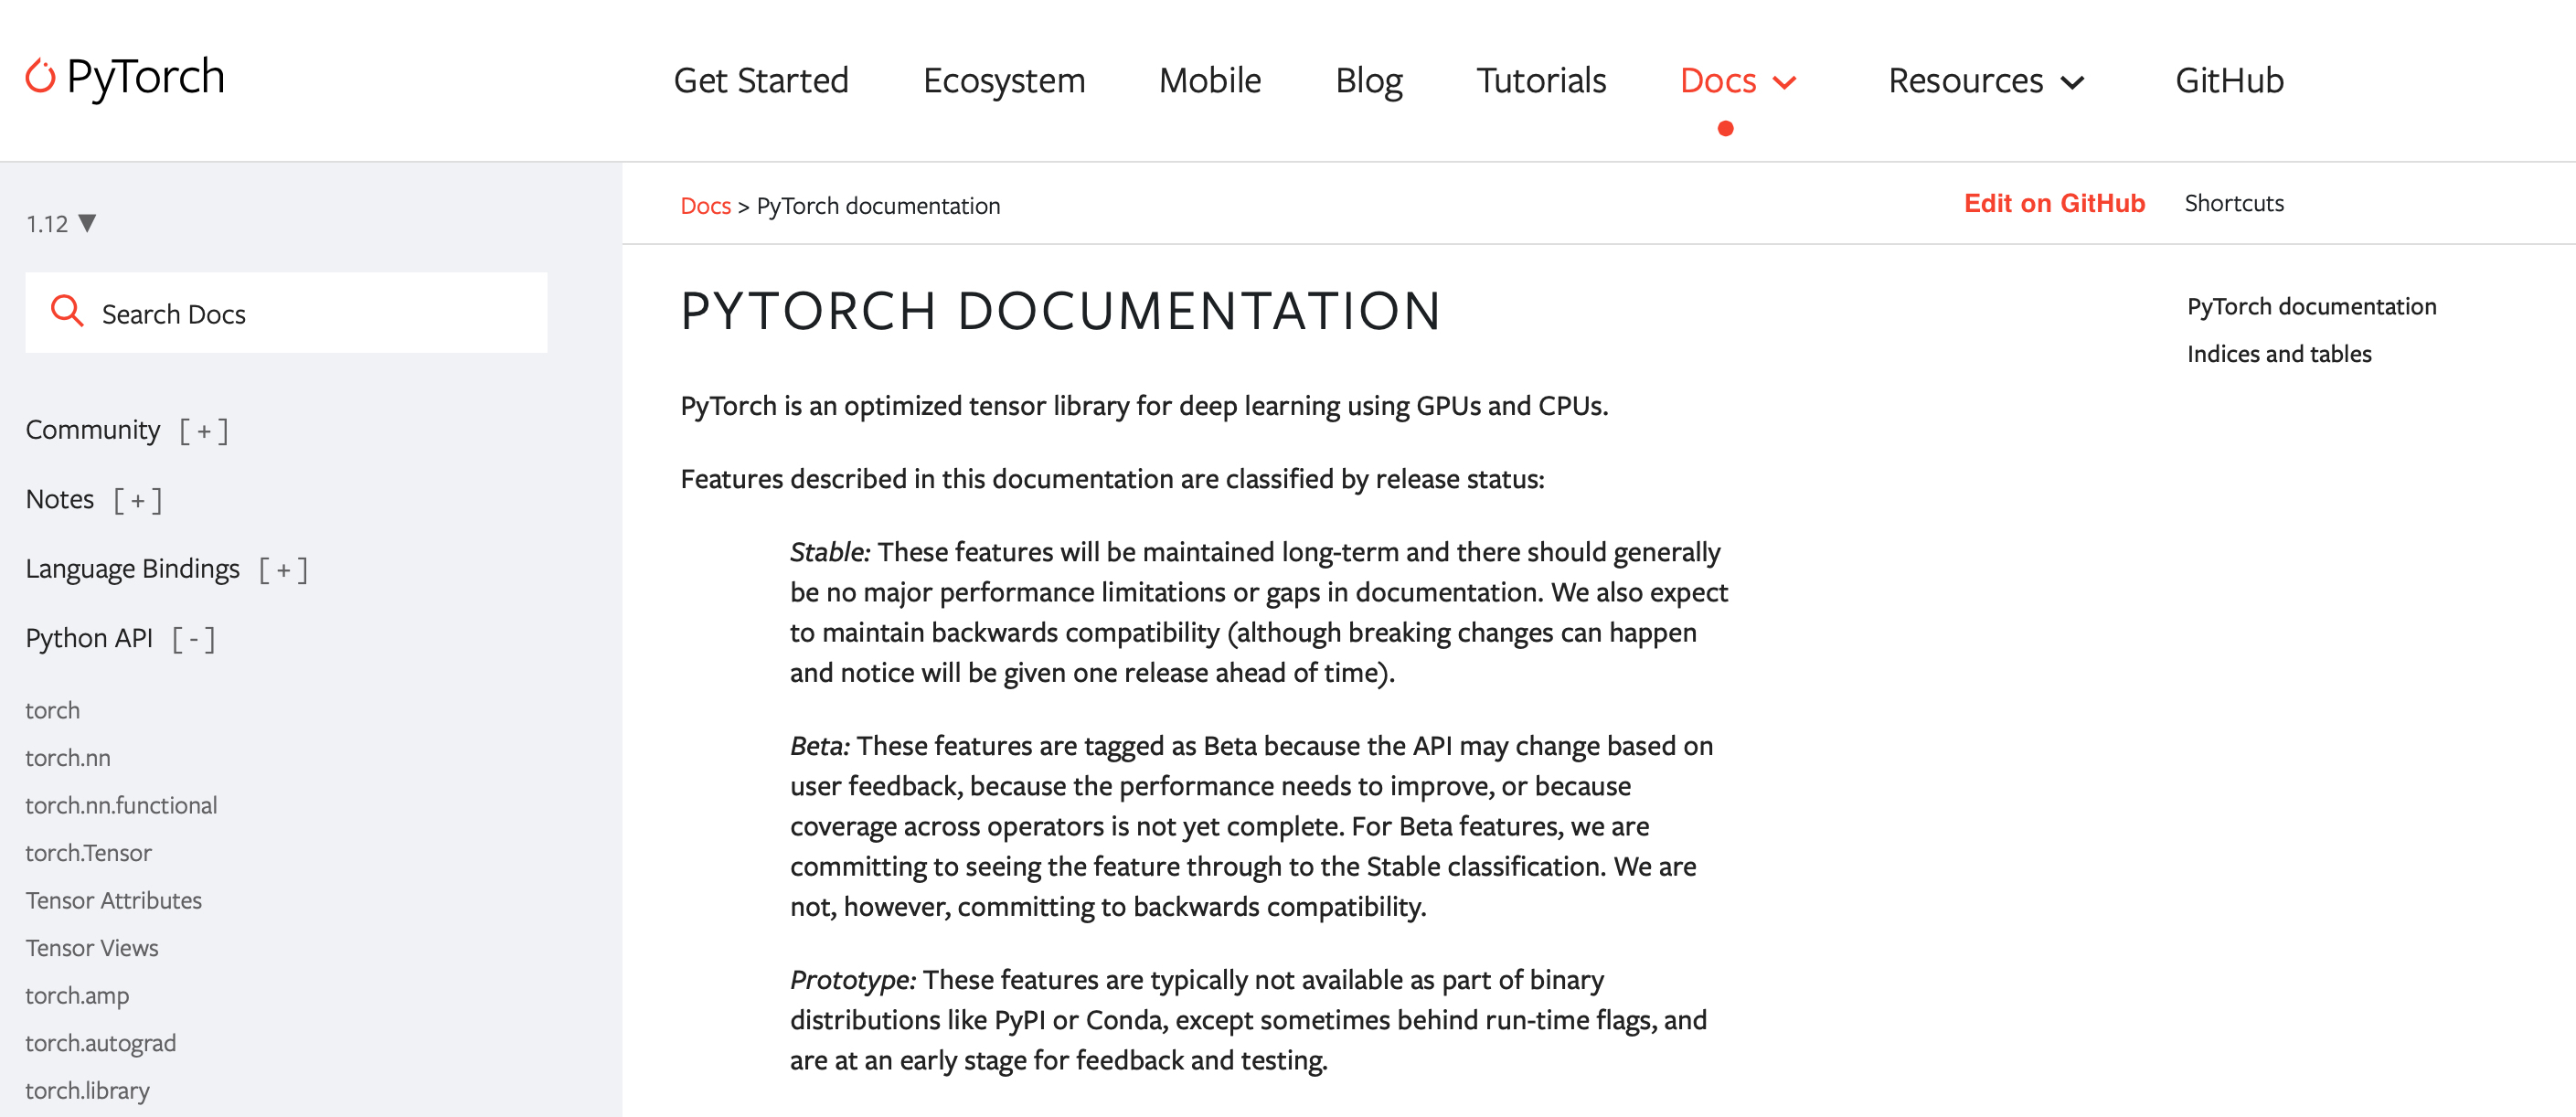